In [1]:
import torch
# 파이토치를 import
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
# 파이토치 라이브러리 안에 있는 Dataset, DataLoader, random_split 학습을 위해서 import
from torchvision import datasets
#CIFA-10데이터셋을 불러오기 위해서 import
import torchvision.transforms as transfroms
# 데이터를 Tensor로 만들어주고 정규화를 위해 import

In [2]:
train_transfrom = transfroms.Compose([
    transfroms.ToTensor(),
    transfroms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# 데이터를 Tensor로 만들어주고 정규화를 시켜줌 각 픽셀의 평균값과 표준편차를 파라미터로 넣어서 정규화를 해줌.
#정규화를 하는 이유는 몇몇의 비교적 값이 큰 data가 scale이 비교적 작은
# data에 비해 모델에 끼치는 영향이 크기 때문에 범위를 맞추어준다. 이것은 overfiting을 억제하는 효과가 있음

training_data = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transfrom)
#datasets으로부터 CIFAR10데이터 다운로드

val_split = 10000
train_split = 40000
training_data, val_data = random_split(
    training_data, [train_split, val_split]
)
# 데이터를 학습 데이터와 검증데이터로 나눔 (총 데이터의 수가 50000개이기 떄문에 40000개 10000개로 나눔)

train_dataloader = DataLoader(training_data, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)
#모델에 data를 넣기 위해서는 DataLoader의 형태가 되야 하므로 DataLoader의 형태로 만들어줌, 데이터의 순서가 섞이게 들어가고 batch_size를 설정해준다.


100%|██████████| 170498071/170498071 [00:13<00:00, 12793984.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
from torchvision.models.resnet import ResNet18_Weights, resnet18
# 모델인 resnet18과 사전학습 되어있는 가중치를 import 해줌
import numpy as np
#넘파이 import

#train
trans_model = resnet18(ResNet18_Weights.IMAGENET1K_V1)
# 사전학습된 모델을 불러온다 이 pretrain된 가중치는 대량의 데이터(imagenet)으로 훈련된 가중치이다.
# 모델을 resnet18로 한 이유는 CIFAR-10데이터는 복잡한 데이터가 아니고 분류의 종류가 10개밖에 안되는 간단한
# 데이터이기 때문에 오히려 깊은 모델인 resnet34나 50을 썻을 때의 정확도가 더 안나올 수 있다고 판단하여 좀 더 얕은 모델인 resnet18을 썻다.
device = 'cuda'
trans_model.to(device)
# 모델을 cpu에서 돌리면 시간이 오래 걸림 따라서 cuda를 이용해서 gpu를 이용
train_size = len(train_dataloader.dataset)
# train데이터 길이
train_batch_num = len(train_dataloader)
# batch의 총 개수가 몇개인가
size = len(train_dataloader.dataset)
# batch의 개수
loss_fn = nn.CrossEntropyLoss()
# 손실함수 정의
# 분류임으로 mAP와같은 손실함수가 아닌 분류문제에 일반적으로 쓰이는 CossEntropy함수를 사용하여 손실함수를 정의한다.
optimizer = torch.optim.Adam(trans_model.parameters(), lr=1e-4)
# optimizer 정의
# Adam은 지금 대부분의 문제에서 대체적으로 양호한 성능을 보이는 optimizer로
# 이전에 나왔던 Adagrad나 RMSProp처럼 각각의 파라미터마다 다른 크기의 업데이트를 진행하지만 여기에 momentum기법을 포함한 방법이다.
train_loss_list = []
train_acc_list = []
# train의 loss값과 acc값의 진척을 보기 위해 값을 기록할 list생성

#val
val_size = len(val_dataloader.dataset)
num_batches = len(val_dataloader)
F_full_images = []
F_full_target = []
val_loss_list = []
val_acc_list = []

for epoch in range(5):
    # epoch값 10번으로 정의
    print(f'[Epoch {epoch}]')
    train_loss = 0
    train_acc = 0
    # train_loss, train_acc값을 담아둘 변수
    for batch, (images, targets) in enumerate(train_dataloader): # train_loader로부터 image, target값을 받아올 반복문
        trans_model.train()
        # 모델을 train으로 정의 eval로 되어있을 경우 배치정규화나 dropout같이 train에 사용되어야하는 기능이 실행이 안됨
        # 그렇기 때문에 train임을 명시해주어 dropout이나 배치정규화를 사용
        images = images.to(device)
        targets = targets.to(device)
        # 받아온 image와 target을 gpu로 보냄

        preds = trans_model(images)
        # training_data를 넣어 예측값 도출
        loss = loss_fn(preds, targets)
        # 예측한 값과 실제의 값을 손실함수를 이용해 loss값 도출
        train_loss += loss.item()
        # train_loss값에 더해줌
        # 더해주는 이유는 지금 배치를 이용한 학습을 하고 있음으로 한 epoch의 모델에 대한 trian_loss값을 측정하기 위해서는 값을 모두 더한 뒤 총 데이터수로 나누어줘야
        # 한 epoch에 대한 loss값이 될 수 있음

        optimizer.zero_grad()
        # 역전파를 하기 전에 optimizer에 남아있는 grad를 0으로 초기화 해줘야 역전파를 했을 때 전에 한 역전파의 영향을 받지 않는다
        loss.backward()
        # 역전파를 한다
        optimizer.step()
        # 매개변수 최적화

        train_acc += (preds.argmax(1) == targets).float().sum().item()
        # 예측한 값과 진짜의 값이 같다면 그 값을 train_acc에 1씩 더해줌
        # 나중에 train_acc값을 데이터의 총 개수로 나누어주는 연산을 이용해 그 모델의 정확도를 측정할 수 있음


        if batch % 10 == 0:
            loss = loss.item()
            current = batch * len(images)
            print(f'epoch:{epoch} loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
        # 중간중간 loss값과 지금까지 얼마나 되었는지를 출력하기 위한 코드
    train_loss_list.append(train_loss/ train_batch_num)
    # train_loss_list에 epoch이 한번 돌았을 때의 총 loss값을 추가
    #위에서 말한 train_loss를 총 train_batch로 나누어줌으로 epoch 하나당 하나의 trian_loss값이 나올 수 있게 함
    train_acc_list.append(train_acc / train_size)
    # train_acc_list에 epoch이 한번 돌았을 때의 총 acc값을 추가
    # 위에서 말한 train_acc 총 train_size 나누어줌으로 epoch 하나당 하나의 trian_loss값이 나올 수 있게 함

    #val
    with torch.no_grad():
        # val일 때는 gradient 트래킹 멈춤
        batch_loss = 0
        batch_corr = 0
        trans_model.eval()
        # 모델을 평가하는 형태로 정의
        # eval을 선언해주지 않는다면 평가할 때는 쓰이면 안되는 dropout기법등이 쓰이게 되어 성능이 안좋아질 수 있음
        for test_batch, (images, targets) in enumerate(val_dataloader): # test_loader로부터 image, target값을 받아올 반복문
            images = images.to(device)
            # val데이터를 gpu로 보냄
            targets = targets.to(device)
            # target데이터를 gpu로 보냄

            preds = trans_model(images)
            # model에 val_data넣어서 예측
            batch_loss += loss_fn(preds, targets).item()
            # batch_loss에 batch의 loss값을 계산해 더해줌
            batch_corr +=(preds.argmax(1) == targets).float().sum().item()
            # 예측한 값과 진짜의 값이 같다면 그 값을 batch_corr 1씩 더해줌

            if ((preds.argmax(1) != targets) and (epoch > 5)):
              #예측 측값이 틀린 것을 찾아서 image로 찍어보기 위한 코드
              #epoch값이 5는 넘어야 model의 학습이 어느정도 진행되었다고 판단하여 epoch의 값이 5를 넘은 시점에만 image저장
                F_full_images.append(images.cpu())
                F_full_target.append(targets.cpu())


            if test_batch % 200 == 0:
                loss = loss_fn(preds, targets).item()
                current = test_batch * len(images)
                print(f'epoch:{epoch} loss: {loss:>7f}  [{current:>5d}/{val_size:>5d}]')
            #중간중간 얼마나 진행되었는지를 보여주기 위한 코드

        val_loss_list.append(batch_loss/num_batches)
        val_acc_list.append(batch_corr/val_size)
        # 검증데이터의 loss값과 acc값의 변화를 보기 위해 list에 추가한다


    print()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.5MB/s]


[Epoch 0]
epoch:0 loss: 12.752090  [    0/40000]
epoch:0 loss: 11.175304  [  320/40000]
epoch:0 loss: 8.272193  [  640/40000]
epoch:0 loss: 7.323830  [  960/40000]
epoch:0 loss: 4.815262  [ 1280/40000]
epoch:0 loss: 4.098464  [ 1600/40000]
epoch:0 loss: 4.408896  [ 1920/40000]
epoch:0 loss: 3.355729  [ 2240/40000]
epoch:0 loss: 3.526811  [ 2560/40000]
epoch:0 loss: 2.589885  [ 2880/40000]
epoch:0 loss: 2.655268  [ 3200/40000]
epoch:0 loss: 3.129667  [ 3520/40000]
epoch:0 loss: 2.362993  [ 3840/40000]
epoch:0 loss: 2.131258  [ 4160/40000]
epoch:0 loss: 2.015065  [ 4480/40000]
epoch:0 loss: 2.017910  [ 4800/40000]
epoch:0 loss: 2.013983  [ 5120/40000]
epoch:0 loss: 2.855496  [ 5440/40000]
epoch:0 loss: 1.578772  [ 5760/40000]
epoch:0 loss: 1.339917  [ 6080/40000]
epoch:0 loss: 2.250261  [ 6400/40000]
epoch:0 loss: 1.184999  [ 6720/40000]
epoch:0 loss: 1.767532  [ 7040/40000]
epoch:0 loss: 1.640704  [ 7360/40000]
epoch:0 loss: 1.354422  [ 7680/40000]
epoch:0 loss: 1.962872  [ 8000/40000]


In [4]:
# 검증할 때 틀린 이미지를 찍어보기 위한 코드
# 이 작업을 한 이유는 검증을 할 때 loss값을 보면 trian할 때와는 다르게 train은 epoch이 6~8정도 되었을 때 어느정도 loss값이
# 0 이하로 작게 나오는 것을 볼 수 있었는데 검증데이터의 loss값을 0이하로 잘 나오다가 몇몇이 4~5정도로 확 튀는 것을 확인했다.
# 그래서 어떤 이미지가 어떠한 이미지인지 한번 보려고 작성한 코드이다.
# 이 이미지를 본 결과 고양이와 말의 부분적인 사진을 잘 구분 못한다는 것을 확인하고 4발이 달린 동물을 잘 구분 못한다는 것은 각 조그마한 부분의
# 특징 추출이 잘 안되었다고 판단해 원래는 VGG모델을 썻었지만 resnet모델로 바꾸게 되었다. 아직도 고양이와 말을 잘 구분못한다는 것은
# 남아있지만 VGG모델을 썻을 때 보다는 고양이 말을 틀리는 비율이 많이 줄었다.
import matplotlib.pyplot as plt
# pyplot을 불러오기 위한 코드
fig = plt.figure()
for num, (image, target) in enumerate(zip(F_full_images[-20:], F_full_target[-20:])): # 보여줄 이미지를 20개만 찍을 것이기 때문에 20개만 가져오는 for문
    image = image[0]
    image = np.transpose(image,  (1, 2, 0))
    # 이미지를 찍을 형태로 변환해줌
    ax = fig.add_subplot(4, 5, num+1)
    ax.imshow(image)
    ax.set_label(target)
    plt.axis('off')
    # 이미지를 출력할 때 격자를 꺼주기 위한 코드
# 예측했는데 틀린 image를 출력하기 위한 코드

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'train_val_accuracy_res')

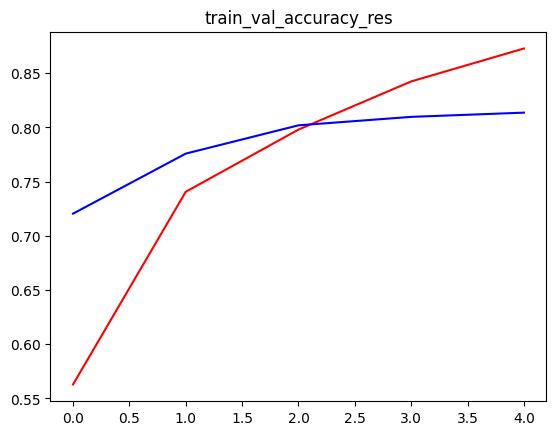

In [5]:
epoch = [num for num in range(5)]
plt.plot(epoch, train_acc_list, color='r')
# epoch에 따른 train데이터의 정확도의 증가를 보는 코드
plt.plot(epoch, val_acc_list, color='b')
# epoch에 따른 val데이터의 정확도 증가를 보는 그래프
plt.title('train_val_accuracy_res')
# 정확도를 볼 수 있는 그래프

Text(0.5, 1.0, 'train_val_loss')

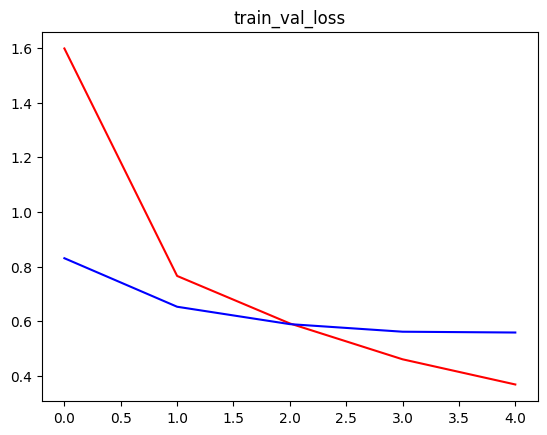

In [6]:
epoch = [num for num in range(5)]
plt.plot(epoch, train_loss_list, color='r')
# epoch에 따른 train데이터의 loss의 감소를 보는 코드
plt.plot(epoch, val_loss_list, color='b')
# epoch에 따른 val데이터의 loss의 감소를 보는 그래프
plt.title('train_val_loss')
# loss값의 감소를 볼 수 있는 코드

In [7]:
print('정확도:', val_acc_list[-1])
# 모델의 정확도 출력

정확도: 0.8136
